In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load SAM

In [3]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

In [4]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [5]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))

In [6]:
print("Image size", np.array(rgb).shape)
# sam_detections["masks"].int().sum(dim=(1,2)).chunk(26)

Image size (480, 640, 3)


# 2. Filter out too small and too big sam proposals

In [89]:
from torchvision.ops.boxes import batched_nms, box_area
import cv2
import numpy as np


def tighten_bboxes(sam_detections, device="cuda"):
    # Apply morphological opening - it does eorion then dilation to remove noise
    kernel = np.ones((5,5), np.uint8)

    filtered_masks = list()
    for mask in sam_detections["masks"].cpu():
        filtered_mask = cv2.morphologyEx(np.array(mask, dtype="uint8"), cv2.MORPH_OPEN, kernel)
        filtered_masks.append(torch.tensor(filtered_mask))
    sam_detections["masks"] = torch.stack(filtered_masks).to(device)
    return sam_detections


def _remove_very_small_detections(masks, boxes): # after this step only valid boxes, masks are saved, other are filtered out
    min_box_size = 0.05 # relative to image size 
    min_mask_size = 300/(640*480) # relative to image size assume the pixesl should be in range (300, 10000) need to remove them 
    max_mask_size = 10000/(640*480) 
    img_area = masks.shape[1] * masks.shape[2]
    box_areas = box_area(boxes) / img_area
    formatted_values = [f'{value.item():.6f}' for value in box_areas*img_area]
    mask_areas = masks.sum(dim=(1, 2)) / img_area
    keep_idxs = torch.logical_and(
        torch.logical_and(mask_areas > min_mask_size, mask_areas < max_mask_size),
        box_areas > min_box_size**2
    )

    return keep_idxs

noise_remove_sam_detections = tighten_bboxes(sam_detections)

keep_ids = _remove_very_small_detections(noise_remove_sam_detections["masks"], noise_remove_sam_detections["boxes"])

selected_masks = [noise_remove_sam_detections["masks"][i] for i in range(len(keep_ids)) if keep_ids[i]]
selected_bboxes = [noise_remove_sam_detections["boxes"][i] for i in range(len(keep_ids)) if keep_ids[i]]

selected_sam_detections = {
    "masks" : torch.stack(selected_masks),
    "boxes" : torch.stack(selected_bboxes)
}

print(len(selected_sam_detections["masks"]))
print(len(sam_detections["masks"]))

90
151


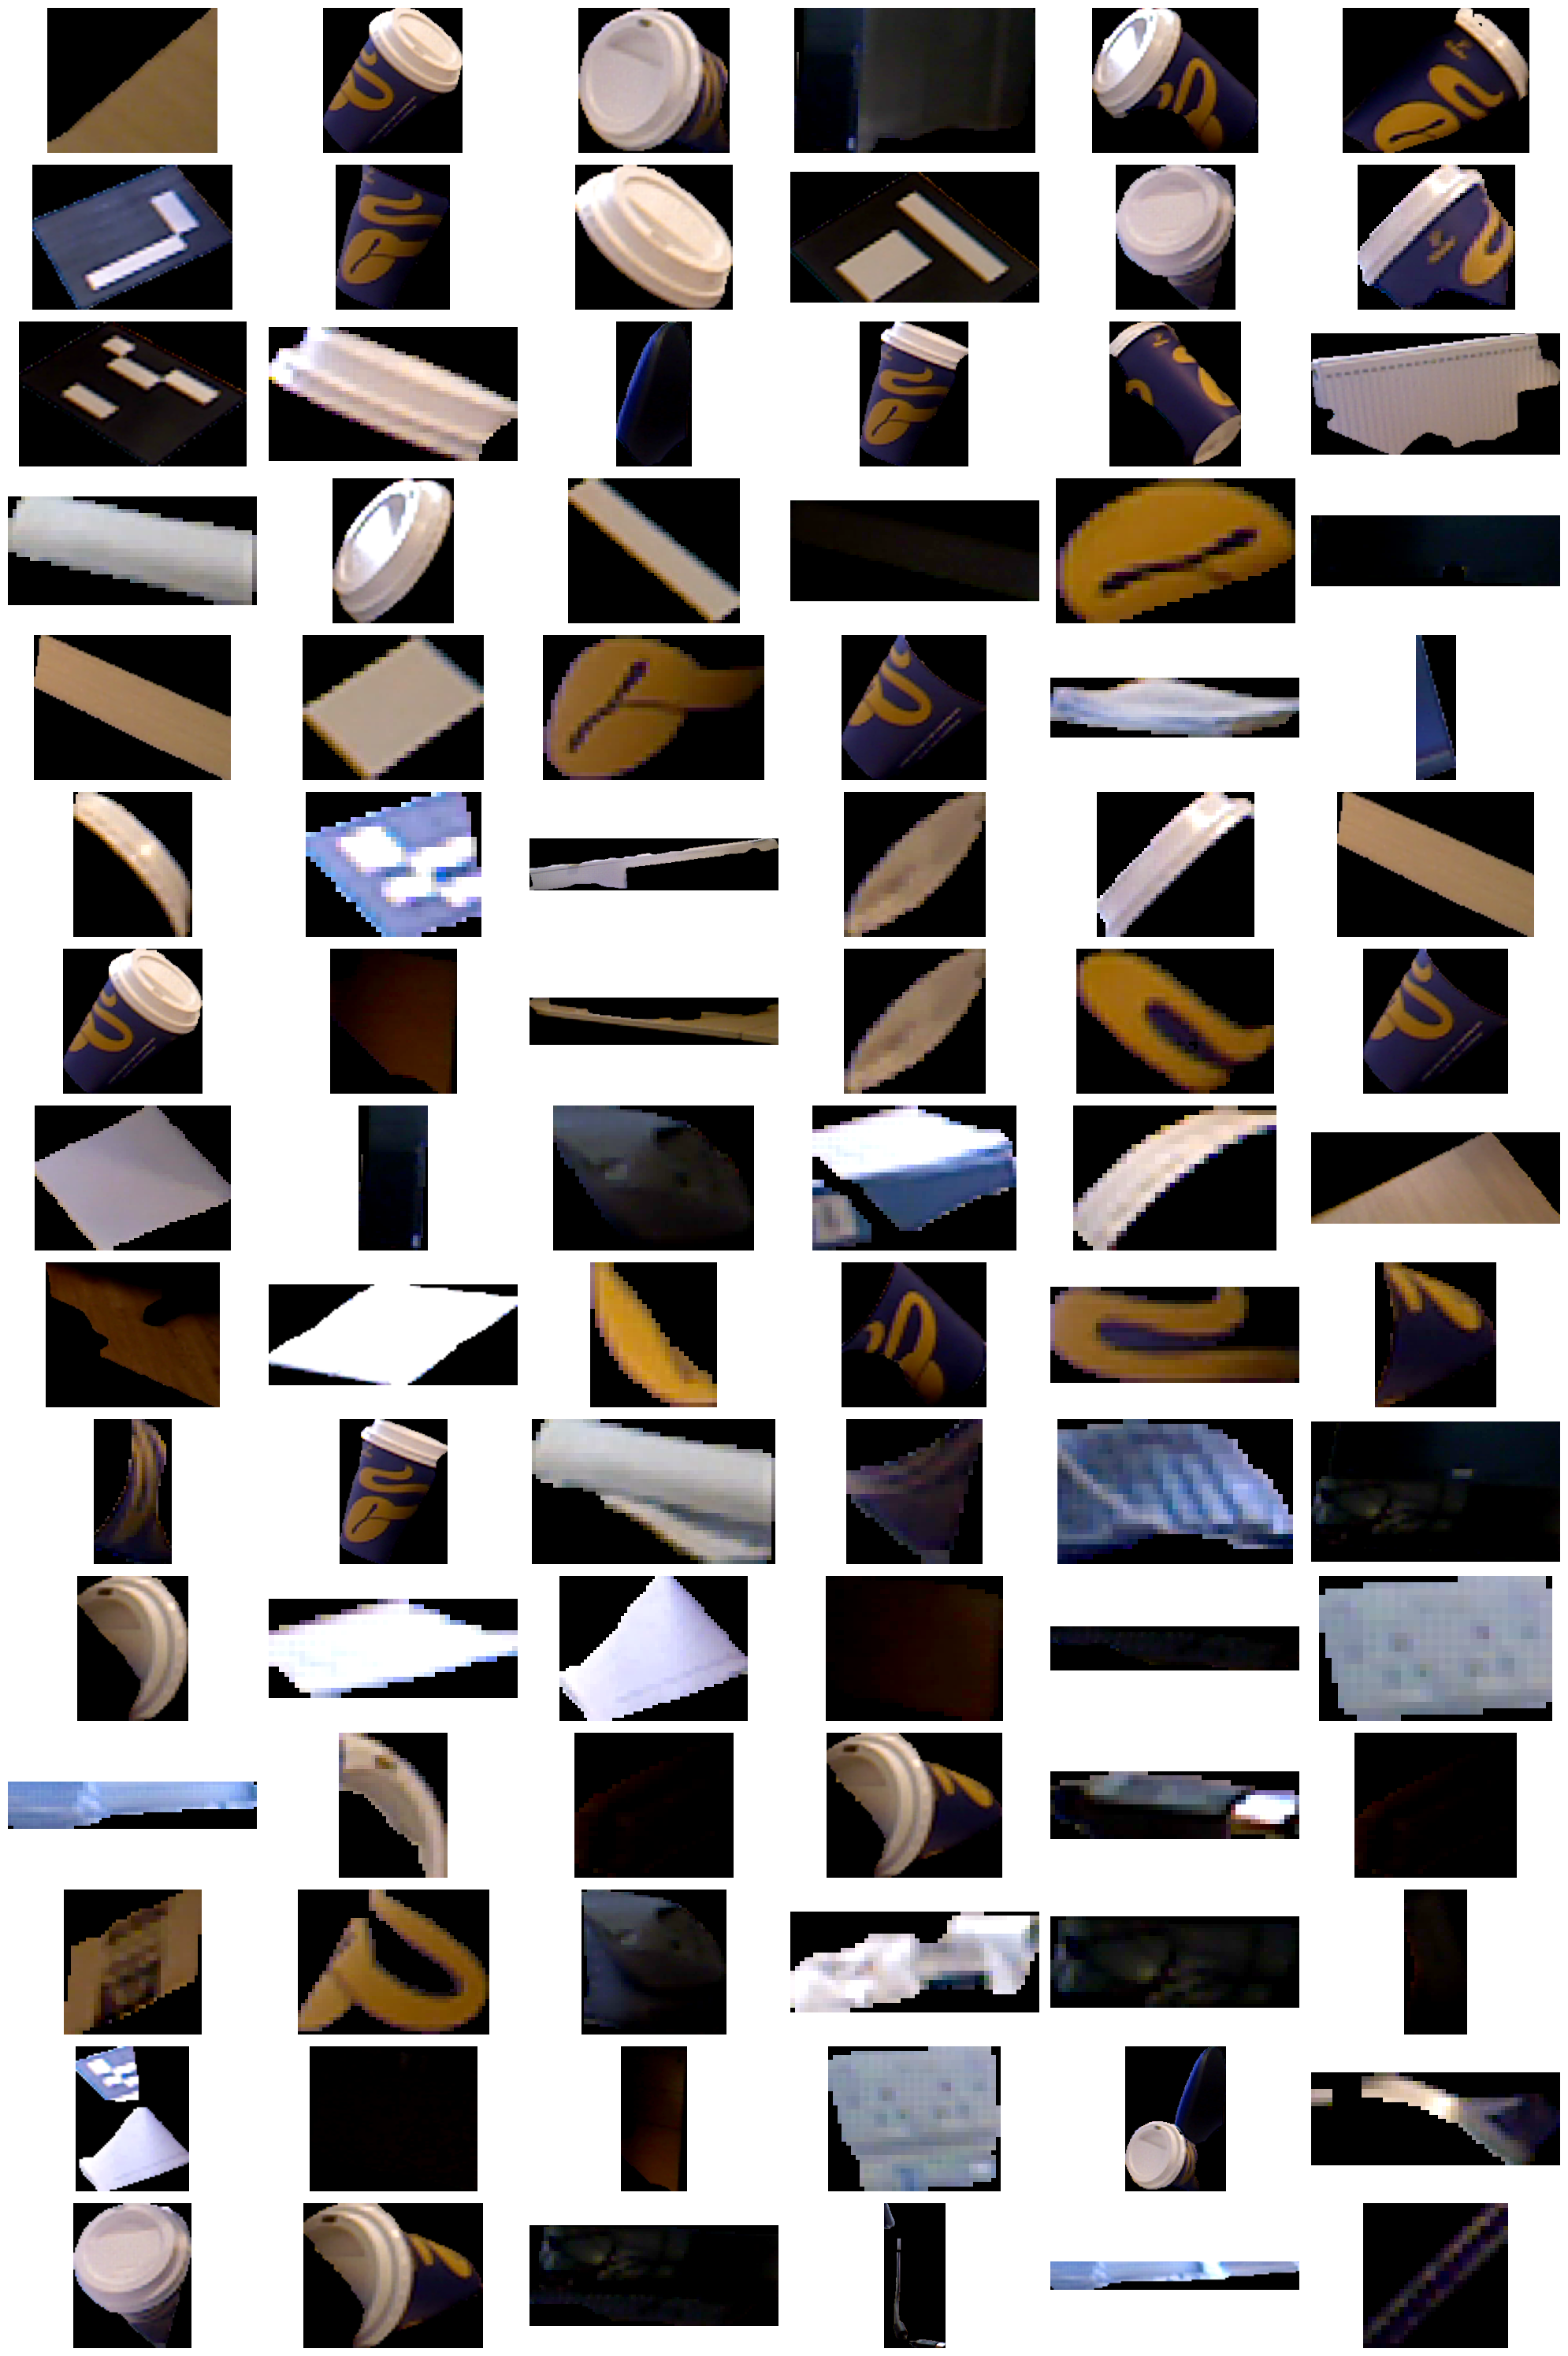

: 

In [91]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in selected_sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [66]:
for i in range(0,20):
    print(f"mask shape of {i}", np.array(masked_images[i]).shape)
    print(f"bbox shape of {i}", selected_bboxes[i])

mask shape of 0 (66, 78, 3)
bbox shape of 0 tensor([562, 413, 639, 478])
mask shape of 1 (124, 157, 3)
bbox shape of 1 tensor([216, 191, 372, 314])
mask shape of 2 (75, 80, 3)
bbox shape of 2 tensor([277, 115, 356, 189])
mask shape of 3 (59, 98, 3)
bbox shape of 3 tensor([445,   0, 542,  58])
mask shape of 4 (98, 110, 3)
bbox shape of 4 tensor([351, 119, 460, 216])
mask shape of 5 (96, 123, 3)
bbox shape of 5 tensor([295, 247, 417, 342])
mask shape of 6 (76, 105, 3)
bbox shape of 6 tensor([127, 344, 231, 419])
mask shape of 7 (100, 77, 3)
bbox shape of 7 tensor([215, 188, 291, 287])
mask shape of 8 (73, 79, 3)
bbox shape of 8 tensor([293, 191, 371, 263])
mask shape of 9 (73, 141, 3)
bbox shape of 9 tensor([337, 406, 477, 478])
mask shape of 10 (85, 70, 3)
bbox shape of 10 tensor([162, 169, 231, 253])
mask shape of 11 (62, 67, 3)
bbox shape of 11 tensor([209, 117, 275, 178])
mask shape of 12 (76, 120, 3)
bbox shape of 12 tensor([479, 335, 598, 410])
mask shape of 13 (40, 73, 3)
bbox sha

In [68]:
len(masked_images)

90

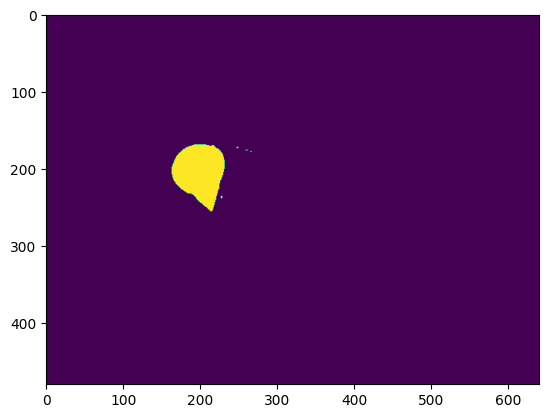

In [20]:
import matplotlib.pyplot as plt

plt.imshow(np.array(selected_sam_detections["masks"][84], dtype="uint8"))

In [60]:
mask_temp = np.array(selected_sam_detections["masks"][84], dtype="uint8")
mask_temp.shape

(480, 640)

In [47]:
selected_sam_detections["bbox"][84]

tensor([163, 169, 266, 255])

In [22]:
mask_temp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# 3. Tighten the bboxes
Erosion and dilation to filter small details 


New bounding box: x=163, y=169, width=69, height=85
Original bounding box: tensor([163, 169, 266, 255], device='cuda:0')


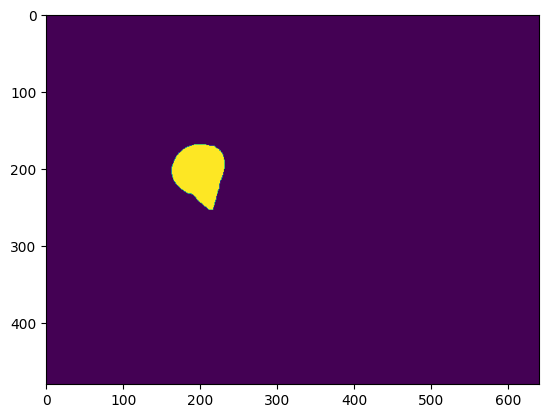

In [75]:
plt.imshow(opened)

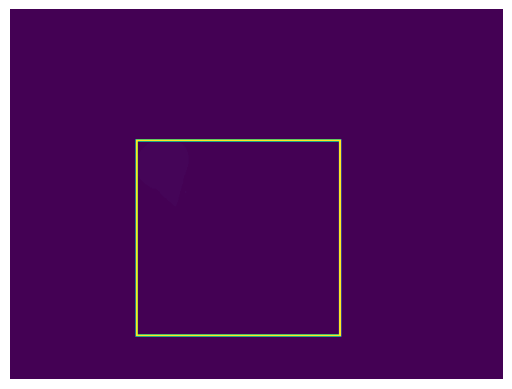

In [58]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

img_temp = Image.fromarray(mask_temp)
# Create a draw object
draw = ImageDraw.Draw(img_temp)

# Draw the bounding box (outline)
draw.rectangle([selected_sam_detections['bbox'][84][0], selected_sam_detections['bbox'][84][1], selected_sam_detections['bbox'][84][0] + selected_sam_detections['bbox'][84][2],
                 selected_sam_detections['bbox'][84][1] + selected_sam_detections['bbox'][84][3]], outline="red", width=3)
# draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

# Display the result
plt.imshow(img_temp)
plt.axis('off')  # Hide axis
plt.show()


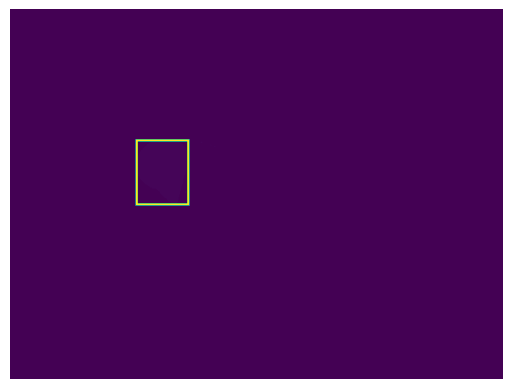

In [46]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

img_temp = Image.fromarray(mask_temp)
# Create a draw object
draw = ImageDraw.Draw(img_temp)

# Draw the bounding box (outline)
# draw.rectangle([original_x, original_y, original_x + original_w, original_y + original_h], outline="red", width=3)
draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

# Display the result
plt.imshow(img_temp)
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
result_img = Image.composite(masked_bbox, img_temp, mask_img)

In [38]:
opened

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)